# Outage probability versus $\gamma_{th}$

## Loading libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
from statsmodels.stats.proportion import proportion_confint

from misc import single_reflection_coordinate
from misc import reflection_coordinates
from misc import reflection_angles
from misc import line_equation_coefficients
from misc import dist_to_obstructions
from misc import blocked_rays_main_paths
from misc import fcombine

## Simulation settings

In [2]:
# np.random.seed(1234)

trials = 100000

GHz  = 60 # operating frequency
c    = 299792458  # speed of light
r    = 0.1  # obtruction radius
lmbd = 0.5  # intensity of the PPP (m^(-2))
sgm2 = 1.658e-11
Pt   = 0.1

# Table 2 (paper)
if (GHz == 18):
    z  = 130
    AO = 0.00006
    f  = 18e9
if (GHz == 26):
    z  = 200
    AO = 0.00013
    f  = 26e9
if (GHz == 60):
    z  = 390
    AO = 0.015
    f  = 60e9
if (GHz == 73):
    z  = 420
    AO = 0.0075
    f  = 73e9

wvlen= c / f
# Refractive indices
n1          = 1
n2          = 1.5

# Antenna gain
GtdB = 20 # Gain at the transmitter in dB   
GrdB = 10 # Gain at the receiver in dB
Gt   = np.power(10, GtdB/10)
Gr   = np.power(10, GrdB/10)
G    = Gr * Gt
B    = sgm2/(Pt * G)

## Room, RIS, Tx, and Rx

In [3]:
# Room dimensions
Lx = 30
Ly = 20
room_area = Lx * Ly

ris_center_x = 7.5
ris_center_y = 0
RIS_antenna = 'Intelligent array'
N = 32
# RIS on the bottom wall
if (ris_center_y == 0):
    x_RIS  = wvlen * (np.linspace(-N/2,(N/2)-1,N) - 0.50) + ris_center_x
    y_RIS  = np.zeros(N) 
    wall = 'bottom'
# RIS on the left wall
if (ris_center_x == 0):
    y_RIS  = wvlen * (np.linspace(-N/2,(N/2)-1,N) - 0.50) + ris_center_y
    x_RIS  = np.zeros(N)
    wall = 'left'
# RIS on the upper wall
if (ris_center_y == Ly):
    x_RIS  = wvlen * (np.linspace(-N/2,(N/2)-1,N) - 0.50) + ris_center_x    # RIS x-coordinates
    y_RIS  = np.ones(N) * Ly
    wall = 'upper'
# RIS on the right wall
if (ris_center_x == Lx):
    y_RIS  = wvlen * (np.linspace(-N/2,(N/2)-1,N) - 0.50) + ris_center_y     # RIS x-coordinates
    x_RIS  = np.ones(N) * Lx
    wall = 'right'


# Transmitter and receiver cooordinates
x_Tx = 1
y_Tx = 1

x_Rx = 1 + 10/np.sqrt(2)
y_Rx = 1 + 10/np.sqrt(2)

## Free path loss

In [4]:
# Reflection path coordinates
xr, yr = reflection_coordinates(Lx, Ly, x_Tx, y_Tx, x_Rx, y_Rx)
# Reflection angles
theta_i = reflection_angles(x_Tx, y_Tx, x_Rx, y_Rx, xr, yr)

# Coefficients of line equations
# LOS path
TxRx = line_equation_coefficients(x_Tx, x_Rx, y_Tx, y_Rx, 'single')
# Tx-Reflection paths
TxRP = line_equation_coefficients(x_Tx, xr, y_Tx, yr, 'multiple')
# Reflection paths-Rx
RPRx = line_equation_coefficients(xr, x_Rx, yr, y_Rx, 'multiple')
# Tx-RIS paths
TxRIS = line_equation_coefficients(x_Tx, x_RIS, y_Tx, y_RIS, 'multiple')
# RIS-Rx paths
RISRx = line_equation_coefficients(x_RIS, x_Rx, y_RIS, y_Rx, 'multiple')
# Tx-RIScenter 
TxRISc = line_equation_coefficients(x_Tx, ris_center_x, y_Tx, ris_center_y, 'single')
# Tx-RIScenter 
RIScRx = line_equation_coefficients(ris_center_x, x_Rx, ris_center_y, y_Rx, 'single')

# Distances
dk      = np.zeros(5)
dk[0]   = np.sqrt(np.power(x_Rx - x_Tx, 2) + np.power(y_Rx - y_Tx, 2))
dk[1:5] = TxRP.d + RPRx.d
dRIS    = TxRIS.d + RISRx.d
dRISc   = TxRISc.d + RIScRx.d

Rs       = np.divide(n1 * np.cos(theta_i) - n2 * np.sqrt(1 - np.power(n1 * np.sin(theta_i) / n2, 2)),
                     n1 * np.cos(theta_i) + n2 * np.sqrt(1 - np.power(n1 * np.sin(theta_i) / n2, 2)))
Rp       = np.divide(n1 * np.sqrt(1 - np.power(n1 * np.sin(theta_i) / n2, 2)) - n2 * np.cos(theta_i),
                     n1 * np.sqrt(1 - np.power(n1 * np.sin(theta_i) / n2, 2)) + n2 * np.cos(theta_i))
Rs       = Rs * np.conj(Rs)
Rp       = Rp * np.conj(Rp)
Rk       = np.divide(2, (Rs+Rp))
Wk       = np.zeros(5)
Lk       = np.zeros(5)
Wk[1:5]  = 10 * np.log10(Rk)

# Free space path loss for LOS path and reflection paths
Lk      = 20 * np.log10(4 * np.pi * f * dk / c) + AO * dk + Wk[0:5]  # Eq. (1)

theta_id = 180/np.pi * theta_i
print('coordinates')
print("Tx:\t (%.2f, %.2f)"%(x_Tx, y_Tx))
print("Rx:\t (%.2f, %.2f)"%(x_Rx, y_Rx))
print('--------------------------------')
print('\t\t LOS\t\t path1\t\t path2\t\t path3\t\t path4')
print('distances[m]\t %.5f\t %.5f\t %.5f\t %.5f\t %.5f'%(dk[0], dk[1], dk[2], dk[3], dk[4]))
print('angles[deg]\t %.5f\t %.5f\t %.5f\t %.5f\t %.5f'%(0, theta_id[0], theta_id[1], theta_id[2], theta_id[3]))
print('W[dB]\t\t %.5f\t %.5f\t %.5f\t %.5f\t %.5f'%(Wk[0], Wk[1], Wk[2], Wk[3], Wk[4]))
print('Lk[dB]\t\t %.5f\t %.5f\t %.5f\t %.5f\t %.5f'%(Lk[0], Lk[1], Lk[2], Lk[3], Lk[4]))
print('--------------------------------')

coordinates
Tx:	 (1.00, 1.00)
Rx:	 (8.07, 8.07)
--------------------------------
		 LOS		 path1		 path2		 path3		 path4
distances[m]	 10.00000	 11.50149	 51.41747	 31.72694	 11.50149
angles[deg]	 0.00000	 37.93708	 7.90452	 12.87781	 37.93708
W[dB]		 0.00000	 13.52086	 13.97875	 13.97471	 13.52086
Lk[dB]		 88.16081	 102.91928	 116.98303	 112.48998	 102.91928
--------------------------------


## Number of obstructions per path and obstruction length per path

In [5]:
start_time = time.time()

num_obs_per_path     = np.zeros((5,trials))
num_obs_per_path_RIS = np.zeros((N,trials))
num_obs_per_path_Rx = np.zeros((N,trials))
num_obs_per_path_Tx = np.zeros((N,trials))

obs_len_per_path     = np.zeros((5,trials))
obs_len_per_path_RIS = np.zeros((N,trials))
obs_len_per_path_Tx = np.zeros((N,trials))
obs_len_per_path_Rx = np.zeros((N,trials))

# no_obstructions = np.random.poisson(lam=lmbd*room_area, size=trials)
no_obstructions = np.random.poisson(lam=lmbd*(Lx - 2 * r)*(Ly - 2 * r), size=trials) 
for ii in range(trials):
    x_1 = (Lx - 2 * r) * np.random.uniform(size=no_obstructions[ii]) + r
    y_1 = (Ly - 2 * r) * np.random.uniform(size=no_obstructions[ii]) + r  
    
    # distance to obstructions (main paths)
    d2o  = np.zeros((len(x_1),9))
    d2o[:,0] = dist_to_obstructions(x_1, y_1, TxRx.A, TxRx.B, TxRx.C)
    d2o[:,1] = dist_to_obstructions(x_1, y_1, TxRP.A[0], TxRP.B[0], TxRP.C[0])
    d2o[:,2] = dist_to_obstructions(x_1, y_1, RPRx.A[0], RPRx.B[0], RPRx.C[0])
    d2o[:,3] = dist_to_obstructions(x_1, y_1, TxRP.A[1], TxRP.B[1], TxRP.C[1])
    d2o[:,4] = dist_to_obstructions(x_1, y_1, RPRx.A[1], RPRx.B[1], RPRx.C[1])
    d2o[:,5] = dist_to_obstructions(x_1, y_1, TxRP.A[2], TxRP.B[2], TxRP.C[2])
    d2o[:,6] = dist_to_obstructions(x_1, y_1, RPRx.A[2], RPRx.B[2], RPRx.C[2])
    d2o[:,7] = dist_to_obstructions(x_1, y_1, TxRP.A[3], TxRP.B[3], TxRP.C[3])
    d2o[:,8] = dist_to_obstructions(x_1, y_1, RPRx.A[3], RPRx.B[3], RPRx.C[3])    
    
    d2o_TxRIS = np.zeros((no_obstructions[ii], N))
    d2o_RISRx = np.zeros((no_obstructions[ii], N))
    for jj in range(N):
        d2o_TxRIS[:,jj] = np.absolute(TxRIS.A[jj]*x_1 + TxRIS.B[jj]*y_1 + TxRIS.C[jj]) / np.sqrt((TxRIS.A[jj]**2) + (TxRIS.B[jj]**2))
        d2o_RISRx[:,jj] = np.absolute(RISRx.A[jj]*x_1 + RISRx.B[jj]*y_1 + RISRx.C[jj]) / np.sqrt((RISRx.A[jj]**2) + (RISRx.B[jj]**2))        

    # Non blocked rays == 0, blocked rays == 1 
    block_ray   = np.zeros((len(x_1),9))
    
    psi = np.arctan((y_Rx - y_Tx)/(x_Rx - x_Tx))
    block_ray[:,0] = blocked_rays_main_paths(x_1, y_1, x_Tx, 
                                                       x_Rx, 
                                                       y_Tx, 
                                                       y_Rx, r, d2o[:,0])    
    block_ray[:,1] = blocked_rays_main_paths(x_1, y_1, x_Tx, 
                                                       xr[0], 
                                                       y_Tx, 
                                                       yr[0], r, d2o[:,1]) 
    block_ray[:,2] = blocked_rays_main_paths(x_1, y_1, xr[0], 
                                                       x_Rx, 
                                                       yr[0], 
                                                       y_Rx, r, d2o[:,2])
    block_ray[:,3] = blocked_rays_main_paths(x_1, y_1, x_Tx, 
                                                       xr[1], 
                                                       y_Tx, 
                                                       yr[1], r, d2o[:,3])
    block_ray[:,4] = blocked_rays_main_paths(x_1, y_1, xr[1], 
                                                       x_Rx, 
                                                       yr[1], 
                                                       y_Rx, r, d2o[:,4])
    block_ray[:,5] = blocked_rays_main_paths(x_1, y_1, x_Tx, 
                                                       xr[2], 
                                                       y_Tx, 
                                                       yr[2], r, d2o[:,5])
    block_ray[:,6] = blocked_rays_main_paths(x_1, y_1, xr[2], 
                                                       x_Rx, 
                                                       yr[2], 
                                                       y_Rx, r, d2o[:,6])
    block_ray[:,7] = blocked_rays_main_paths(x_1, y_1, x_Tx, 
                                                       xr[3], 
                                                       y_Tx, 
                                                       yr[3], r, d2o[:,7])
    block_ray[:,8] = blocked_rays_main_paths(x_1, y_1, xr[3], 
                                                       x_Rx, 
                                                       yr[3], 
                                                       y_Rx, r, d2o[:,8])
    
    
    br_TxRIS = np.zeros((no_obstructions[ii], N))
    br_RISRx = np.zeros((no_obstructions[ii], N))
    for jj in range(N):
        xTmin = np.min([x_Tx, x_RIS[jj]]) - r
        xTmax = np.max([x_Tx, x_RIS[jj]]) + r
        yTmin = np.min([y_Tx, y_RIS[jj]]) - r
        yTmax = np.max([y_Tx, y_RIS[jj]]) + r
        br_TxRIS[:,jj] = (((x_1 >= xTmin) & (x_1 <= xTmax)) & ((y_1 >= yTmin) & (y_1 <= yTmax))) & (d2o_TxRIS[:,jj] < r)
        
        xRmin = np.min([x_Rx, x_RIS[jj]]) - r
        xRmax = np.max([x_Rx, x_RIS[jj]]) + r
        yRmin = np.min([y_Rx, y_RIS[jj]]) - r
        yRmax = np.max([y_Rx, y_RIS[jj]]) + r
        br_RISRx[:,jj] = (((x_1 >= xRmin) & (x_1 <= xRmax)) & ((y_1 >= yRmin) & (y_1 <= yRmax))) & (d2o_RISRx[:,jj] < r)        
   
    # number of blocked rays
    num_obs_per_path[0,ii] = np.sum(block_ray[:,0])
    num_obs_per_path[1,ii] = np.sum((block_ray[:,1].astype(bool) + block_ray[:,2].astype(bool)))
    num_obs_per_path[2,ii] = np.sum((block_ray[:,3].astype(bool) + block_ray[:,4].astype(bool)))
    num_obs_per_path[3,ii] = np.sum((block_ray[:,5].astype(bool) + block_ray[:,6].astype(bool)))
    num_obs_per_path[4,ii] = np.sum((block_ray[:,7].astype(bool) + block_ray[:,8].astype(bool)))
    num_obs_per_path_RIS[:,ii] = np.sum((br_TxRIS.astype(bool) + br_RISRx.astype(bool)), axis=0)
    num_obs_per_path_Rx[:,ii] = np.sum(br_RISRx.astype(bool), axis=0)
    num_obs_per_path_Tx[:,ii] = np.sum(br_TxRIS.astype(bool), axis=0)
                    
    obs_pos = np.multiply(r**2 - np.power(d2o,2), block_ray)
    obs_pos_TxRIS = 2 *  np.sqrt(np.multiply(r**2 - np.power(d2o_TxRIS,2), br_TxRIS))
    obs_pos_RISRx = 2 *  np.sqrt(np.multiply(r**2 - np.power(d2o_RISRx,2), br_RISRx))
                    
    # obstruction lengths 
    obs_pos_split = np.sum(2 * np.sqrt(obs_pos),axis=0)
    obs_len_per_path[0,ii] = obs_pos_split[0]
    obs_len_per_path[1,ii] = obs_pos_split[1] + obs_pos_split[2] 
    obs_len_per_path[2,ii] = obs_pos_split[3] + obs_pos_split[4]
    obs_len_per_path[3,ii] = obs_pos_split[5] + obs_pos_split[6]
    obs_len_per_path[4,ii] = obs_pos_split[7] + obs_pos_split[8]
    obs_len_per_path_RIS[:,ii] = np.sum(obs_pos_TxRIS + obs_pos_RISRx, axis=0)
    obs_len_per_path_Tx[:,ii] = np.sum(obs_pos_TxRIS, axis=0)
    obs_len_per_path_Rx[:,ii] = np.sum(obs_pos_RISRx, axis=0)
        
print("Elapsed time: %s seconds ---" % (time.time() - start_time))

Elapsed time: 287.9691832065582 seconds ---


## Probability of outage

In [6]:
a1_apprx = np.power(10, 0.1 * (Lk.reshape(-1,1) + z * r * 0.5 * np.pi * num_obs_per_path))
a1_exact = np.power(10, 0.1 * (Lk.reshape(-1,1) + z * obs_len_per_path))

Psi1_apprx = a1_apprx[np.argmin(a1_apprx, axis=0), np.arange(0,trials)]
Psi1_exact = a1_exact[np.argmin(a1_exact, axis=0), np.arange(0,trials)]

Psi2_apprx = a1_apprx[0,:]
Psi2_exact = a1_exact[0,:]

Fcombine = fcombine(wall, 
                    RIS_antenna, 
                    x_RIS, 
                    y_RIS, 
                    x_Tx, 
                    y_Tx, 
                    x_Rx, 
                    y_Rx, 
                    3, 
                    (Gt/2) - 1, 
                    (Gr/2) - 1)

D_obs_apprx    = np.sqrt(np.power(10, z * r * (np.pi/2) * num_obs_per_path_RIS / 10))
Dair           = np.sqrt(np.power(10, AO * (TxRIS.d + RISRx.d - 2*r) / 10))
den_apprx      = Dair.reshape(-1,1) * D_obs_apprx * TxRIS.d.reshape(-1,1) * RISRx.d.reshape(-1,1)
num            = np.repeat(np.sqrt(Fcombine.reshape(-1,1)), trials, axis=1)
RIS_term_apprx = 20 * np.log10(np.sum(np.divide(num, den_apprx), axis=0))

LkRIS  = 20 * np.log10(4 * np.pi/((wvlen/2)**2))

a1_apprx_RIS        = np.zeros((6,trials))
a1_apprx_RIS[0:5,:] = np.power(10, 0.1 * (Lk.reshape(-1,1) + z * r * 0.5 * np.pi * num_obs_per_path))
a1_apprx_RIS[5,:]   = np.power(10, 0.1 * (LkRIS.reshape(-1,1) - RIS_term_apprx))


D_obs_exact    = np.sqrt(np.power(10, z * obs_len_per_path_RIS / 10))
den_exact      = Dair.reshape(-1,1) * D_obs_exact * TxRIS.d.reshape(-1,1) * RISRx.d.reshape(-1,1)
RIS_term_exact = 20 * np.log10(np.sum(np.divide(num, den_exact), axis=0))

a1_exact_RIS        = np.zeros((6,trials))
a1_exact_RIS[0:5,:] = np.power(10, 0.1 * (Lk.reshape(-1,1) + z * obs_len_per_path))
a1_exact_RIS[5,:]   = np.power(10, 0.1 * (LkRIS.reshape(-1,1) - RIS_term_exact))

if (wall=='bottom'):
    if ((x_RIS[0] < xr[3]) & (x_RIS[-1] > xr[3])):
        a1_apprx_RIS = np.delete(aX_apprx_RIS, 4, 0)
        a1_exact_RIS = np.delete(aX_exact_RIS, 4, 0)
if (wall=='upper'):
    if ((x_RIS[0] < xr[2]) & (x_RIS[-1] > xr[2])):
        a1_apprx_RIS = np.delete(aX_apprx_RIS, 3, 0)
        a1_exact_RIS = np.delete(aX_exact_RIS, 3, 0)
if (wall=='left'):
    if ((y_RIS[0] < yr[0]) & (y_RIS[-1] > yr[0])):
        a1_apprx_RIS = np.delete(aX_apprx_RIS, 1, 0)
        a1_exact_RIS = np.delete(aX_exact_RIS, 1, 0)
if (wall=='right'):
    if ((y_RIS[0] < yr[1]) & (y_RIS[-1] > yr[1])):
        a1_apprx_RIS = np.delete(aX_apprx_RIS, 2, 0)
        a1_exact_RIS = np.delete(aX_exact_RIS, 2, 0)

Psi1_apprx_RIS = a1_apprx_RIS[np.argmin(a1_apprx_RIS, axis=0), np.arange(0,trials)]
Psi1_exact_RIS = a1_exact_RIS[np.argmin(a1_exact_RIS, axis=0), np.arange(0,trials)]




sqr_h = np.power(np.random.rayleigh(scale=1.0/np.sqrt(2), size=trials), 2)
gamma_th = np.linspace(-100, 100, 201)

compare1 = (np.divide(np.repeat(sqr_h.reshape(1,-1), len(gamma_th), axis=0),
                      np.repeat(Psi1_apprx.reshape(1,-1), len(gamma_th), axis=0)).T <= B * np.power(10, 0.1 * gamma_th).reshape(1,-1))
outage1  = np.sum(compare1, axis=0) * (1 / trials)
CI1      = proportion_confint(np.sum(compare1, axis=0), trials, alpha=0.05, method='normal')

compare2 = (np.divide(np.repeat(sqr_h.reshape(1,-1), len(gamma_th), axis=0),
                      np.repeat(Psi1_exact.reshape(1,-1), len(gamma_th), axis=0)).T <= B * np.power(10, 0.1 * gamma_th).reshape(1,-1))
outage2  = np.sum(compare2, axis=0) * (1 / trials)
CI2      = proportion_confint(np.sum(compare2, axis=0), trials, alpha=0.05, method='normal')

compare3 = (np.divide(np.repeat(sqr_h.reshape(1,-1), len(gamma_th), axis=0),
                      np.repeat(Psi2_apprx.reshape(1,-1), len(gamma_th), axis=0)).T <= B * np.power(10, 0.1 * gamma_th).reshape(1,-1))
outage3  = np.sum(compare3, axis=0) * (1 / trials)
CI3      = proportion_confint(np.sum(compare3, axis=0), trials, alpha=0.05, method='normal')

compare4 = (np.divide(np.repeat(sqr_h.reshape(1,-1), len(gamma_th), axis=0),
                      np.repeat(Psi2_exact.reshape(1,-1), len(gamma_th), axis=0)).T <= B * np.power(10, 0.1 * gamma_th).reshape(1,-1))
outage4  = np.sum(compare4, axis=0) * (1 / trials)
CI4      = proportion_confint(np.sum(compare4, axis=0), trials, alpha=0.05, method='normal')

compare5 = (np.divide(np.repeat(sqr_h.reshape(1,-1), len(gamma_th), axis=0),
                      np.repeat(Psi1_apprx_RIS.reshape(1,-1), len(gamma_th), axis=0)).T <= B * np.power(10, 0.1 * gamma_th).reshape(1,-1))
outage5  = np.sum(compare5, axis=0) * (1 / trials)
CI5      = proportion_confint(np.sum(compare5, axis=0), trials, alpha=0.05, method='normal')

compare6 = (np.divide(np.repeat(sqr_h.reshape(1,-1), len(gamma_th), axis=0),
                      np.repeat(Psi1_exact_RIS.reshape(1,-1), len(gamma_th), axis=0)).T <= B * np.power(10, 0.1 * gamma_th).reshape(1,-1))
outage6  = np.sum(compare6, axis=0) * (1 / trials)
CI6      = proportion_confint(np.sum(compare6, axis=0), trials, alpha=0.05, method='normal')

## Figure 

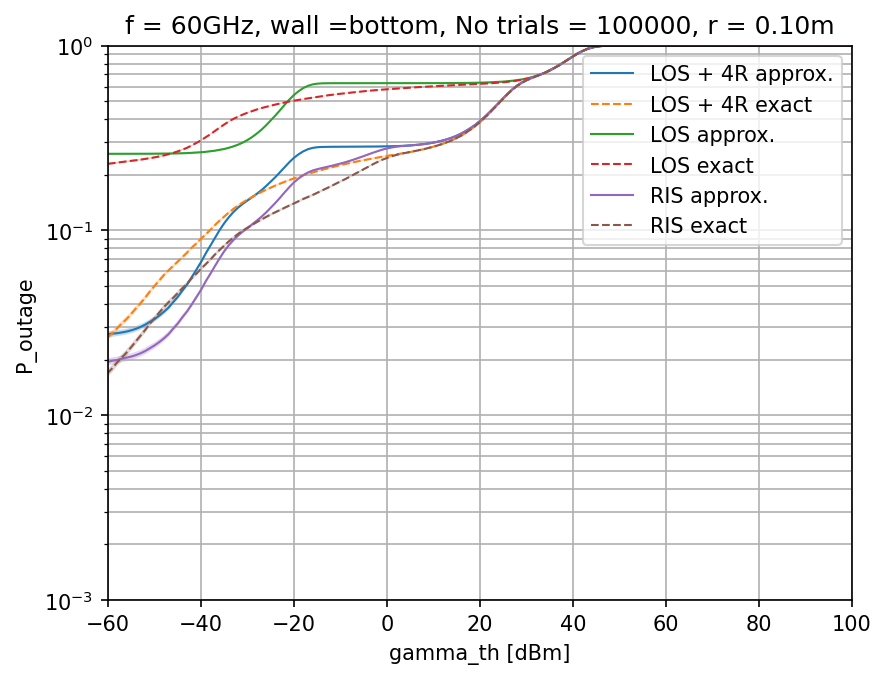

In [7]:
fig = plt.figure(dpi=150)
plt.plot(gamma_th, outage1, lw=1, label= 'LOS + 4R approx.')
plt.fill_between(gamma_th, CI1[0], CI1[1], alpha=0.25)
plt.plot(gamma_th, outage2, '--', lw=1, label= 'LOS + 4R exact')
plt.fill_between(gamma_th, CI2[0], CI2[1], alpha=0.25)
plt.plot(gamma_th, outage3, lw=1, label= 'LOS approx.')
plt.fill_between(gamma_th, CI3[0], CI3[1], alpha=0.25)
plt.plot(gamma_th, outage4, '--', lw=1, label= 'LOS exact')
plt.fill_between(gamma_th, CI4[0], CI4[1], alpha=0.25)
plt.plot(gamma_th, outage5, lw=1, label= 'RIS approx.')
plt.fill_between(gamma_th, CI5[0], CI5[1], alpha=0.25)
plt.plot(gamma_th, outage6, '--', lw=1, label= 'RIS exact')
plt.fill_between(gamma_th, CI6[0], CI6[1], alpha=0.25)

plt.xlim(-60, 100)
plt.ylim([0.001, 1])
plt.grid(which='both')
plt.yscale('log')
plt.ylabel('P_outage')
plt.xlabel('gamma_th [dBm]')
plt.title('f = %dGHz, wall =%s, No trials = %d, r = %.2fm'%(GHz, wall, trials, r))
plt.legend()
plt.show()

## Save data

In [8]:
data_to_save = gamma_th
data_to_save = np.vstack((data_to_save, outage1))
data_to_save = np.vstack((data_to_save, CI1[0]))
data_to_save = np.vstack((data_to_save, CI1[1]))
data_to_save = np.vstack((data_to_save, outage2))
data_to_save = np.vstack((data_to_save, CI2[0]))
data_to_save = np.vstack((data_to_save, CI2[1]))
data_to_save = np.vstack((data_to_save, outage3))
data_to_save = np.vstack((data_to_save, CI3[0]))
data_to_save = np.vstack((data_to_save, CI3[1]))
data_to_save = np.vstack((data_to_save, outage4))
data_to_save = np.vstack((data_to_save, CI4[0]))
data_to_save = np.vstack((data_to_save, CI4[1]))
data_to_save = np.vstack((data_to_save, outage5))
data_to_save = np.vstack((data_to_save, CI5[0]))
data_to_save = np.vstack((data_to_save, CI5[1]))
data_to_save = np.vstack((data_to_save, outage6))
data_to_save = np.vstack((data_to_save, CI6[0]))
data_to_save = np.vstack((data_to_save, CI6[1]))               
                
np.savetxt('FigData/Po_vs_gamma_%dGHz_N%d'%(GHz, N) + '.dat', np.transpose(data_to_save))